<a href="https://colab.research.google.com/github/pszemraj/ai-msgbot/blob/main/colab-notebooks/analyze_gridsearch_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid Search for Parameters

- optimal "text bot" hyperparamters are not really known, nor is there a right answer
- proposal: iterate through "reasonable" parameter ranges, record output, compute sentence coherence scoring on outputs
- evaluate results once finished

## formatting

In [1]:
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

## GPU / CPU status

In [2]:
from psutil import virtual_memory
import os
ram_gb = round(virtual_memory().total / (1024**3), 1)
print('Runtime has {} gigs of memory and {} processors'.format(ram_gb,
      os.cpu_count()))


Runtime has 51.0 gigs of memory and 8 processors


In [3]:
!nvidia-smi

Wed Oct 20 04:25:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# setup

In [4]:
!pip install -U -q pandas
!pip uninstall -y -q pyarrow
!pip install -U -q pyarrow
!pip install -U -q openpyxl
import pandas as pd

In [5]:
!pip3 install -q torch==1.9.1+cu111  -f https://download.pytorch.org/whl/torch_stable.html


In [6]:
%%capture
!pip install -U tqdm
!pip install clean-text

import gc
import os
import pprint as pp
import time
import warnings
from datetime import datetime
from os.path import join


from tqdm.auto import tqdm
from cleantext import clean
warnings.filterwarnings(action="ignore", message=".*gradient_checkpointing*")

In [7]:
!pip uninstall -y -q plotly
!pip install -U -q plotly
import plotly.express as px

In [8]:

def create_folder(directory):
    os.makedirs(directory, exist_ok=True)


def shorten_title(title_text, max_no=35):
    if len(title_text) < max_no:
        return title_text
    else:
        return title_text[:max_no] + "..."


def cleantxt_wrap(ugly_text):
    # a wrapper for clean text with options different than default

    # https://pypi.org/project/clean-text/
    cleaned_text = clean(
        ugly_text,
        fix_unicode=True,  # fix various unicode errors
        to_ascii=True,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_numbers=False,  # replace all numbers with a special token
        no_digits=False,  # replace all digits with a special token
        no_currency_symbols=True,  # replace all currency symbols with a special token
        no_punct=True,  # remove punctuations
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="<URL>",
        replace_with_email="<EMAIL>",
        replace_with_phone_number="<PHONE>",
        replace_with_number="<NUM>",
        replace_with_digit="0",
        replace_with_currency_symbol="<CUR>",
        lang="en",  # set to 'de' for German special handling
    )

    return cleaned_text

### dropbox 


- [tutorial](https://python.plainenglish.io/automate-your-pdf-upload-to-dropbox-python-script-bdacc2c721f6)
- [api docs](https://dropbox-sdk-python.readthedocs.io/en/latest/api/dropbox.html?highlight=files_upload#dropbox.dropbox_client.Dropbox.files_upload)

In [9]:
dropbox_subfolder = "GPT text gen"  # @param {type:"string"}

In [10]:
!pip install -q dropbox
import dropbox

In [11]:
token = "7JM1V7L7-0kAAAAAAAAAAc1mKnyh-G-4YwfL2o9WNJ2Tdh2JJslf_U5IxGrgb-J-"

dbx = dropbox.Dropbox(token)
pp.pprint(dbx.users_get_current_account(), compact=True, indent=4)

FullAccount(account_id='dbid:AAAYVJX_n2JYa7yh6anfANmwSJ7qkr-u8Do', account_type=AccountType('pro', None), country='CH', disabled=False, email='peterszemraj@gmail.com', email_verified=True, is_paired=False, locale='en', name=Name(abbreviated_name='PS', display_name='Peter Szemraj', familiar_name='Peter', given_name='Peter', surname='Szemraj'), profile_photo_url='https://dl-web.dropbox.com/account_photo/get/dbaphid%3AAACl3aYwbYAysBHXpGdGBXZj6IYsXocikxc?size=128x128&vers=1628569648991', referral_link='https://www.dropbox.com/referrals/AAAVOEoeLmg4Nw7hRIA9Wsn8OMf2_EdGbik?src=app9-10920512', root_info=UserRootInfo(home_namespace_id='9560958', root_namespace_id='9560958'), team=NOT_SET, team_member_id=NOT_SET)


In [12]:
def get_size_mb(path2file, verbose=False):

    file_stats = os.stat(path2file)

    file_size_mb = {file_stats.st_size / (1024 * 1024)}
    if verbose: print(f'File Size in MegaBytes is {file_size_mb}')
    return round(list(file_size_mb)[0],2) # returns rounded to 2 decimals

In [13]:
from os.path import join, basename, dirname
import time, random
from google.colab import files

def put_in_dropbox(
    vm_path, subfolder=dropbox_subfolder, no_printout=True, ncalls=0, max_calls=3
):
    if ncalls > max_calls:
        return "failed saving to DropBox - {} tries".format(ncalls)
    elif get_size_mb(vm_path) > 155:
        files.download(vm_path)
        return "file size of {} too big to put in DB, downloading".format(basename(vm_path))
    # for an item on the colab machine on path, upload to dropbox app folder at
    # subfolder/"filename"
    base_filename = basename(vm_path)
    db_path = "/{}/{}".format(subfolder, base_filename)
    try:
        with open(vm_path, "rb") as f:
            dbx.files_upload(f.read(), path=db_path, autorename=True, mute=no_printout)
    except:
        print(
            "WARNING - unable to post in dropbox, retry no. {} - ".format(ncalls + 1),
            datetime.now(),
        )
        time.sleep(random.randint(1, 3))  # small delay before trying again
        put_in_dropbox(vm_path, ncalls=ncalls + 1)  # recursion for retrying

In [14]:
from datetime import date
# for filesaving purposes
today = date.today()
# Month abbreviation, day and year
today_string = today.strftime("%b-%d-%Y")

# Analysis

In [15]:
dl_link = "https://www.dropbox.com/s/9wzzeogl3obahey/GPT-Peter774M-gridsearch-Oct-20-2021_03-06.xlsx?dl=1" #@param {type:"string"}


In [16]:
error_string = "<bro, there was an error. try again>"

df_analysis = pd.read_excel(dl_link, index_col=0).convert_dtypes()
df_analysis = df_analysis[df_analysis["model_response"] != error_string]
df_analysis.reset_index(drop=True, inplace=True)
df_analysis.info(verbose=True) # overview

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            750 non-null    Float64
 1   topk            750 non-null    Int64  
 2   top_p           750 non-null    Float64
 3   prompt          750 non-null    string 
 4   speaker         750 non-null    string 
 5   model_response  750 non-null    string 
dtypes: Float64(2), Int64(1), string(3)
memory usage: 37.5 KB


assume the outputs are a single sentence and then use a [sentence-scoring algorithm on them](https://github.com/simonepri/lm-scorer) via `lm-scorer` package.

- [here](https://colab.research.google.com/github/simonepri/lm-scorer/blob/master/examples/lm_scorer.ipynb) is an example notebook

In [17]:
!pip install -q lm-scorer

import torch
from lm_scorer.models.auto import AutoLMScorer as LMScorer

# Available models
list(LMScorer.supported_model_names())
# => ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", distilgpt2"]

# Load model to cpu or cuda
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 1
scorer = LMScorer.from_pretrained("gpt2-large", device=device,
                                  batch_size=batch_size)
print("loaded - ", datetime.now())

loaded -  2021-10-20 04:26:44.245474


In [18]:
# example

# Compute sentence score as the geometric mean of tokens' probabilities
scorer.sentence_score("I like this package.", reduce="gmean")

0.009417757391929626

In [19]:
# create helper fn

def score_text_blob(gen_text: str, method="gmean", verbose=False):
    # for method 'mean', 
    try:
        return scorer.sentence_score(gen_text, reduce=method)
    except:
        if verbose: print(f"failed computing scores for {gen_text}")
        return 0 # score sentences that failed at 0 - assumption = too undecipherable


### apply and see results

In [20]:
df_analysis.head()

,temp,topk,top_p,prompt,speaker,model_response
0,0.58,0,0.64,what's up?,calvin miller,oh boy i will let you know if they fail to ope...
1,0.58,25,0.64,what's up?,calvin miller,okay. i'm sitting here tonight. maybe during t...
2,0.58,50,0.64,what's up?,calvin miller,beautiful the guy is bringing me my steam
3,0.58,75,0.64,what's up?,calvin miller,statistic bruh my prof from staros's but i wil...
4,0.58,100,0.64,what's up?,calvin miller,i am the better


In [21]:
import time
st = time.time()
df_analysis["model_response"] = df_analysis["model_response"].apply(str)
df_analysis["model_response"] = df_analysis["model_response"].apply(cleantxt_wrap)
df_analysis["geom_score"] = df_analysis["model_response"].apply(score_text_blob)
df_analysis["prod_score"] = df_analysis["model_response"].apply(score_text_blob, 
                                                                args=("prod",))

rt = (time.time() - st) / 60 # minutes
print(f"the total runtime was {rt} minutes")

the total runtime was 1.0329475124677023 minutes


## basic - plotly

- [plotly express docs](https://plotly.com/python/plotly-express/)

In [22]:
fig_temp = px.histogram(df_analysis, x="geom_score", color="topk",
                        marginal="box", # or violin, rug
                        hover_data=df_analysis.columns, template="plotly_dark",
                        title="Geometric Score Dist for different top_k values",
                        height=720, width=int(720*1.613))
fig_temp.show()

In [23]:
fig_temp = px.histogram(df_analysis, x="prod_score", color="topk",
                        marginal="box", # or violin, rug
                        hover_data=df_analysis.columns, template="ggplot2",
                        title="Product Score Dist for different top_k values",
                        log_y=True, 
                        height=720, width=int(720*1.613))
fig_temp.show()

In [24]:
df_analysis.columns

Index(['temp', 'topk', 'top_p', 'prompt', 'speaker', 'model_response',
       'geom_score', 'prod_score'],
      dtype='object')

In [25]:
px.scatter_matrix(df_analysis, template="plotly_dark", 
                    dimensions=['temp', 'topk', 'top_p','geom_score', 'prod_score'],
                    height=720, width=int(720*1.613),
                  title="scatter matrix - all quant vars")


## autoviz


In [26]:
save_av = False #@param {type:"boolean"}


In [27]:
%%capture
!pip install -U autoviz

In [28]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()
filename = "for_autoviz.csv"

df_analysis.to_csv(filename, index=False)

Imported AutoViz_Class version: 0.0.84. Call using:
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 does not show plot but creates them and saves them in AutoViz_Plots directory in your local machine.


In [29]:
sep = ","
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="geom_score",
    dfte=None,
    header=0,
    verbose=2,
    lowess=True,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)


Shape of your Data Set loaded: (750, 8)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
Data Set Shape: 750 rows, 7 cols
Data Set columns info:
* temp: 0 nulls, 5 unique vals, most common: {0.58: 150, 0.92: 150}
* topk: 0 nulls, 6 unique vals, most common: {0: 125, 25: 125}
* top_p: 0 nulls, 25 unique vals, most common: {0.64: 30, 0.92: 30}
* prompt: 0 nulls, 1 unique vals, most common: {"what's up?": 750}
* speaker: 0 nulls, 1 unique vals, most common: {'calvin miller': 750}
* model_response: 0 nulls, 608 unique vals, most common: {'been there 😅 they should succeed': 48, 'my address is 800 niggaz be wila and nothing else': 12}
* prod_score: 0 nulls, 519 unique vals, most common: {0.0: 92, 2.9310727823629342e-27: 48}
--------------------------------------------------------------------
    Numeric Columns: ['top_p', 'prod_score', 'temp']
    Integer-Categorical Columns: ['topk']
    String-Categorical Columns: []
    Fac

In [30]:
import shutil
from pathlib import Path
autopath = Path("/content/AutoViz_Plots")
av_arc = "GPT-Peter Hyperparam Opt_autoviz_plots_{}".format(today_string)
shutil.make_archive(av_arc, "gztar", autopath)

if save_av: put_in_dropbox(av_arc + ".tar.gz")

## sweetviz

In [31]:
!pip install -q sweetviz
import sweetviz as sv

df_sv = df_analysis.copy().convert_dtypes()

feature_config = sv.FeatureConfig(skip=['prompt', 'speaker', 'model_response',],
                                  force_num=['temp', 'topk', 'top_p',
                                             'geom_score', 'prod_score'],
                                  )



df_sv = df_sv[['temp', 'topk', 'top_p', 'geom_score', 'prod_score']]

df_sv = df_sv.astype(float)

df_sv["model_response"] = df_analysis["model_response"].astype(str)
df_sv["model_response"] = df_sv["model_response"].astype("string")
df_sv.info()
# df_sv["topk"] = df_sv["topk"].astype(float)
# df_sv["topk"] = df_sv["topk"].astype(float)
# arameters are skip, force_cat, force_num and force_text. 

     |████████████████████████████████| 15.1 MB 15.6 MB/s 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            750 non-null    float64
 1   topk            750 non-null    float64
 2   top_p           750 non-null    float64
 3   geom_score      750 non-null    float64
 4   prod_score      750 non-null    float64
 5   model_response  750 non-null    string 
dtypes: float64(5), string(1)
memory usage: 35.3 KB


In [32]:
my_report = sv.analyze(df_sv, 
                       target_feat="geom_score")

sv_eda_name = "GPT-Peter Hyperparam Opt-SWEETVIZ-EDA-{}.html".format(today_string)

my_report.show_html(filepath=sv_eda_name,
                    layout='vertical',) # Default arguments will generate to "SWEE

                                             |          | [  0%]   00:00 -> (? left)

Report GPT-Peter Hyperparam Opt-SWEETVIZ-EDA-Oct-20-2021.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



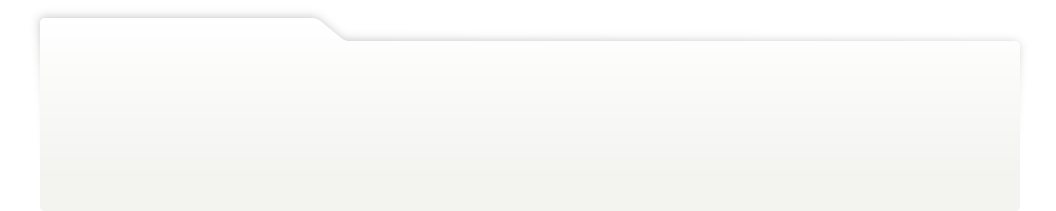
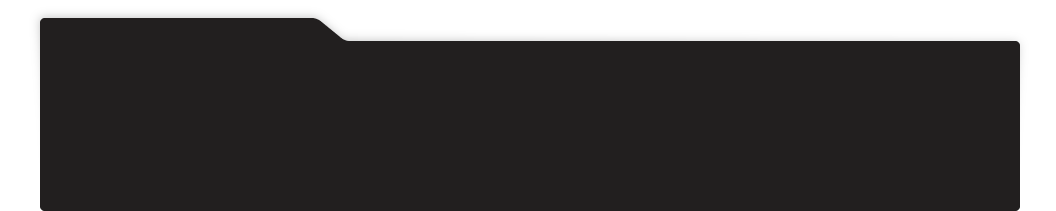
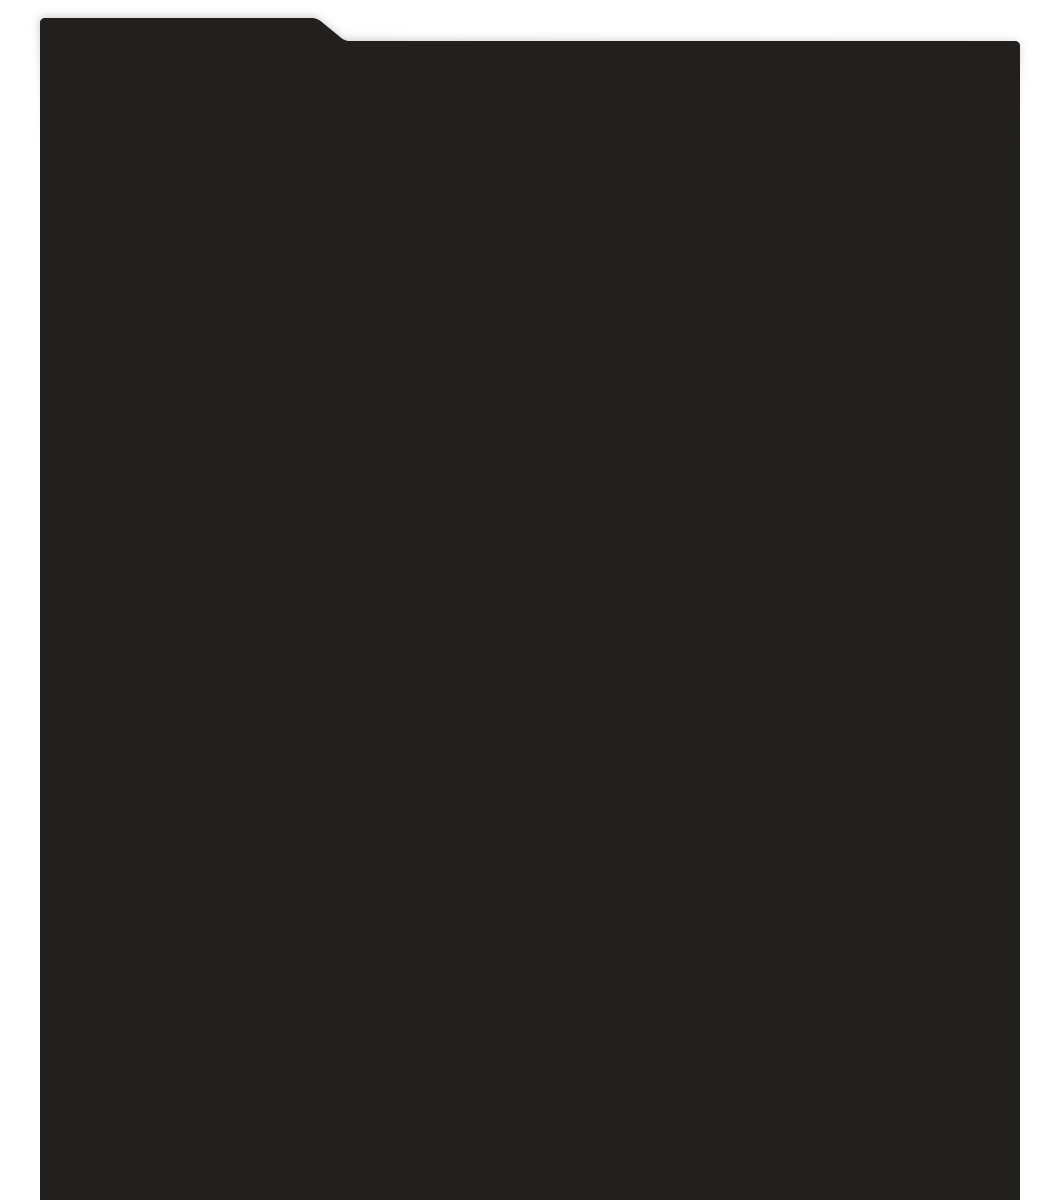
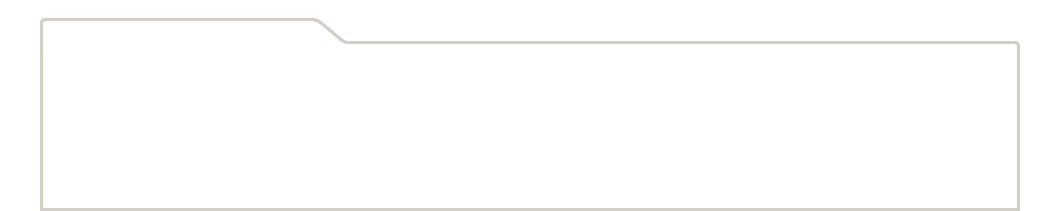
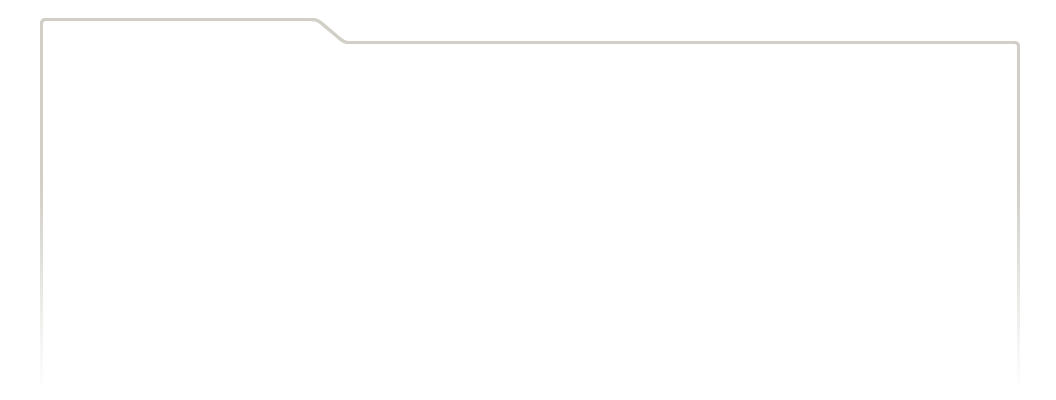
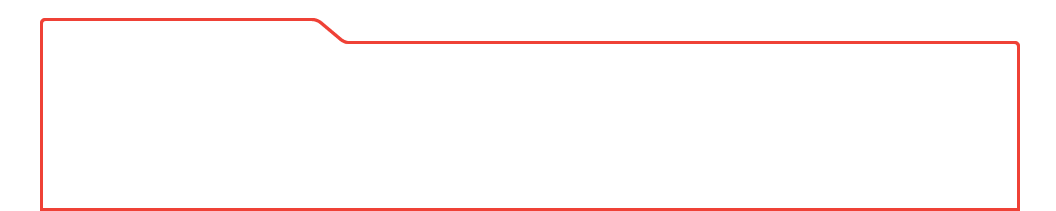
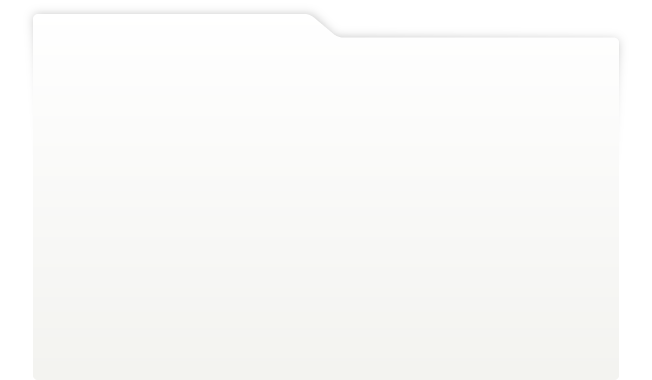
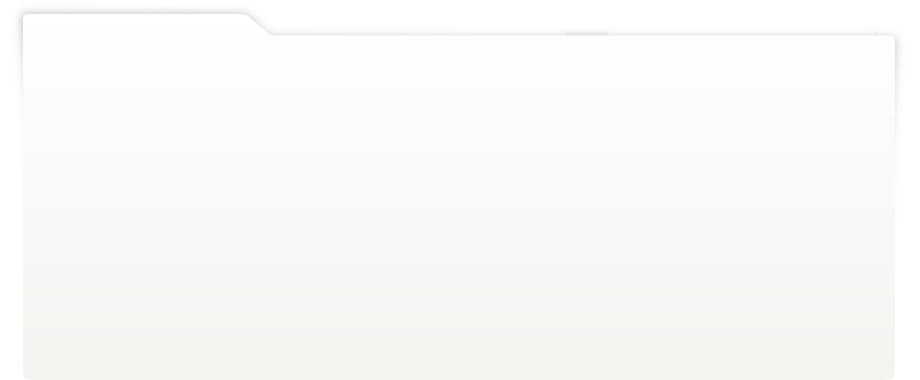
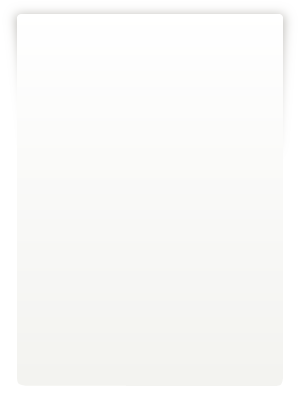
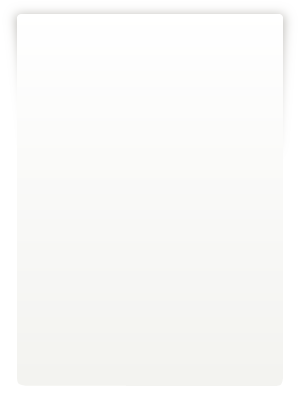
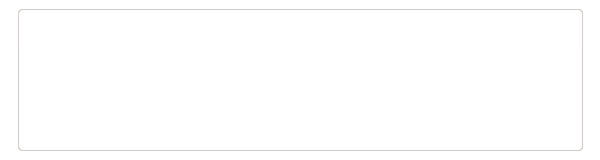
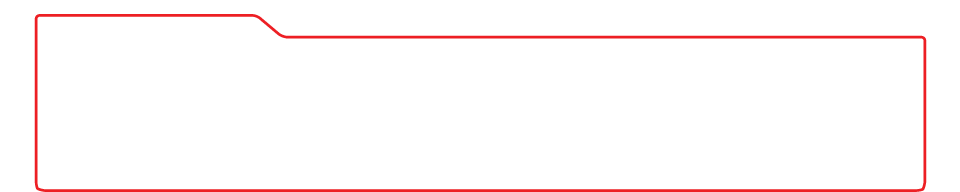
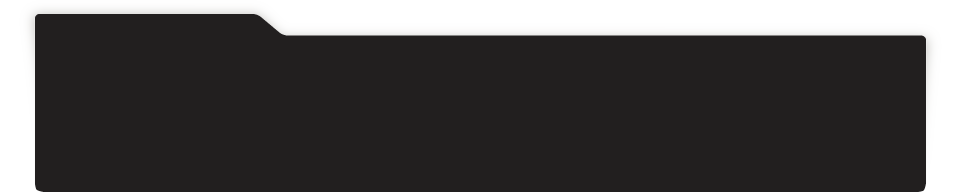
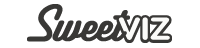
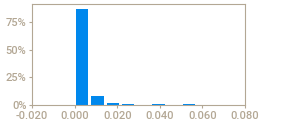
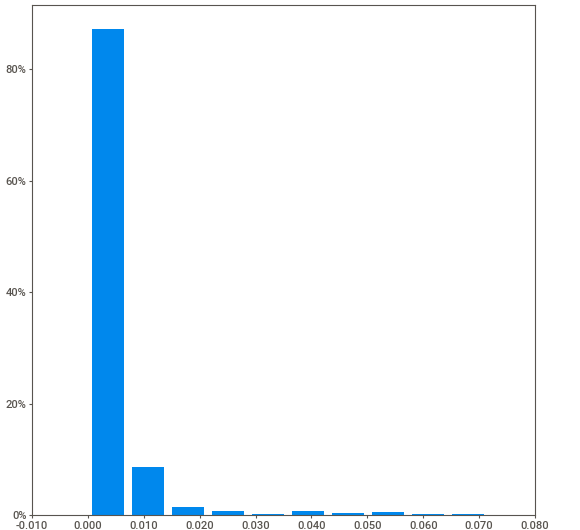
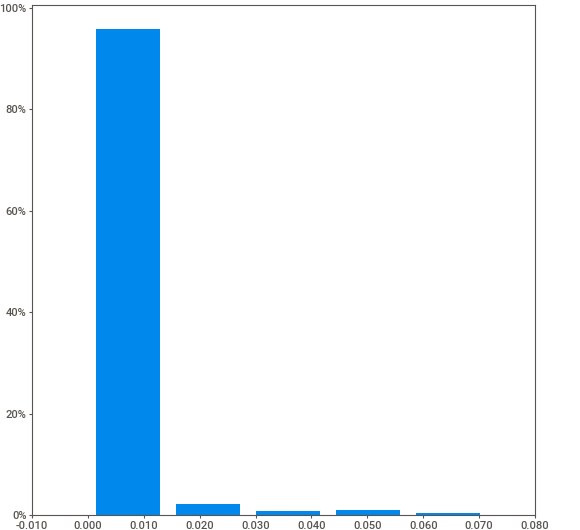
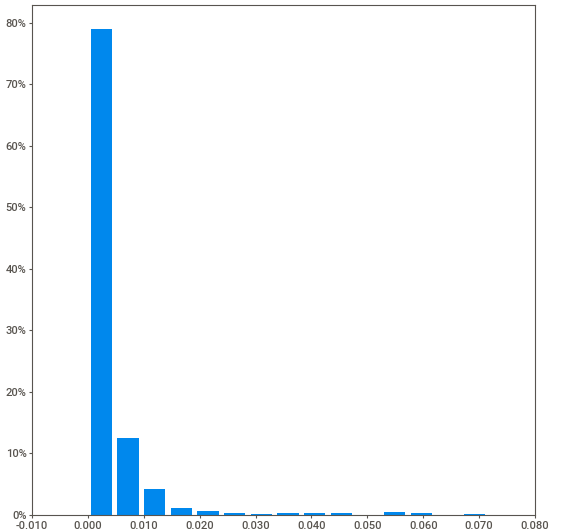
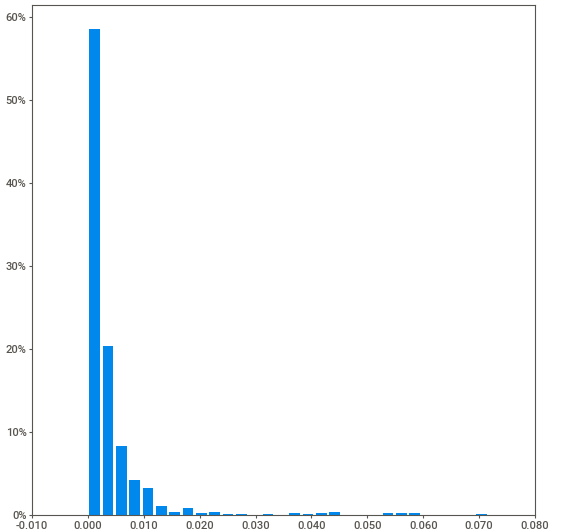
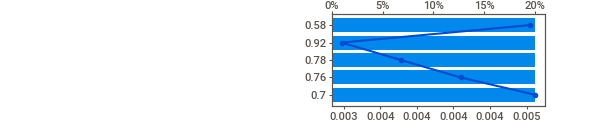
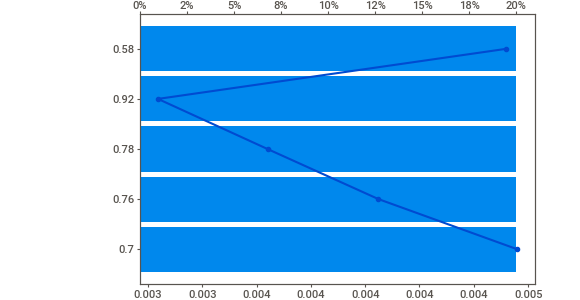
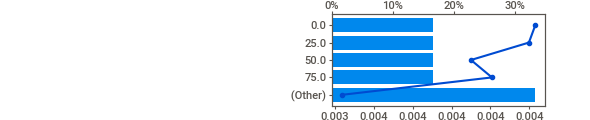
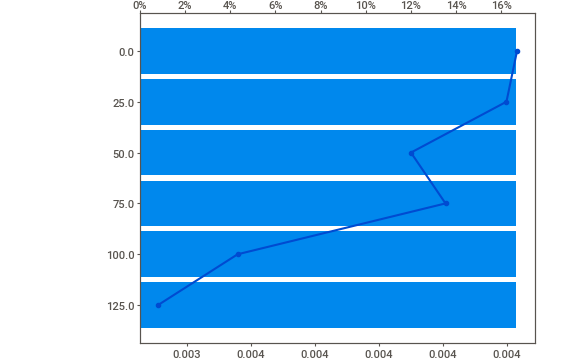
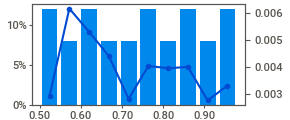
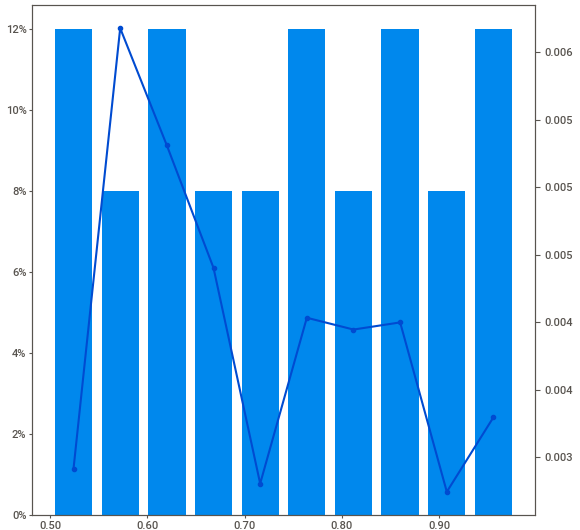
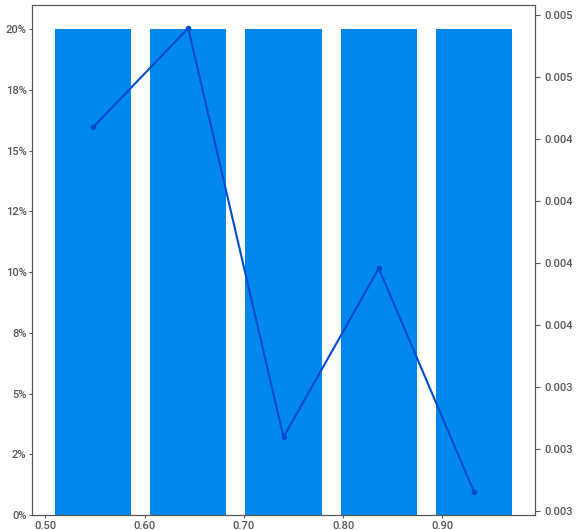
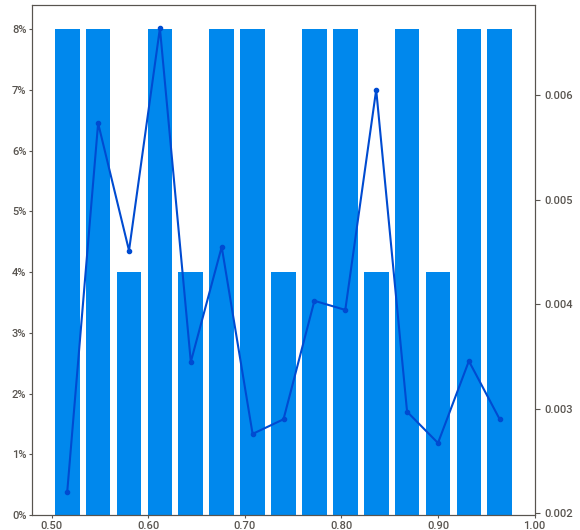
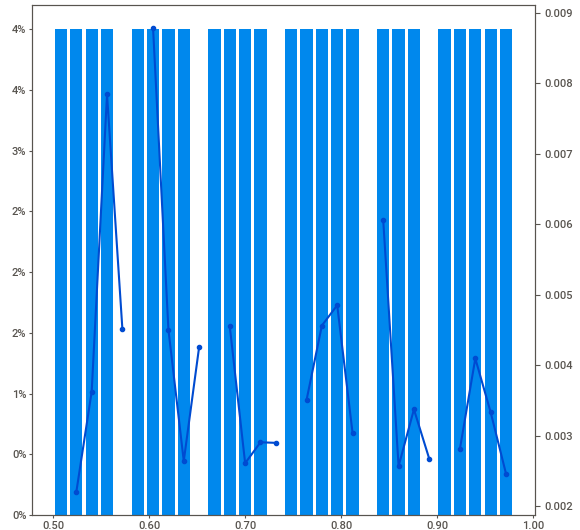
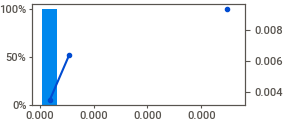
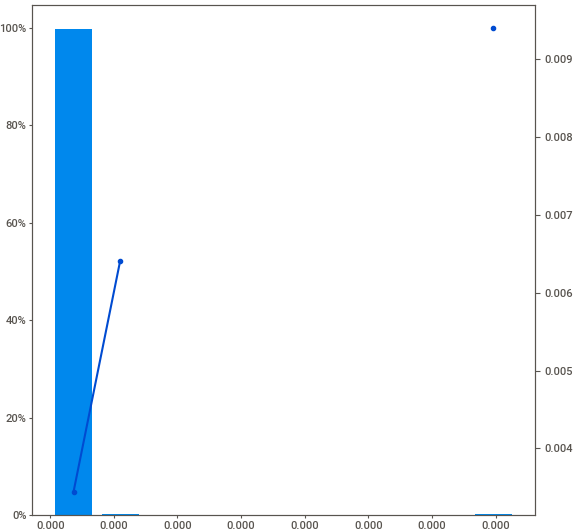
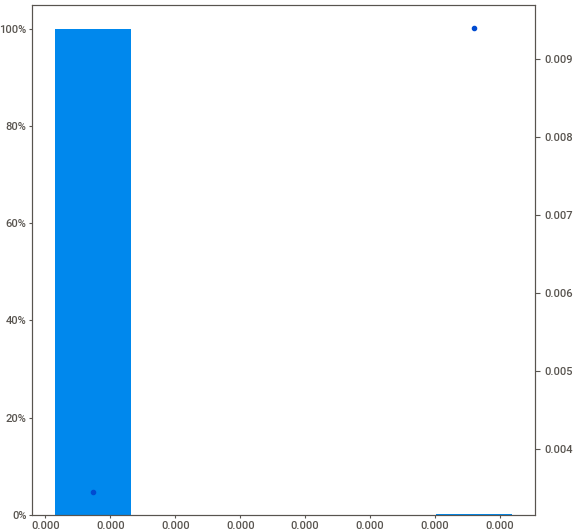
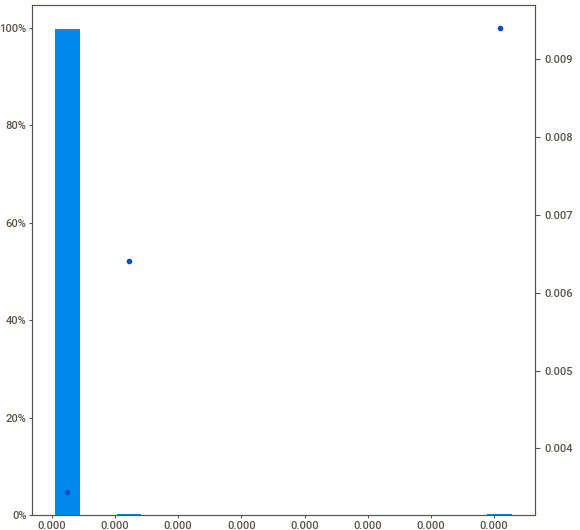
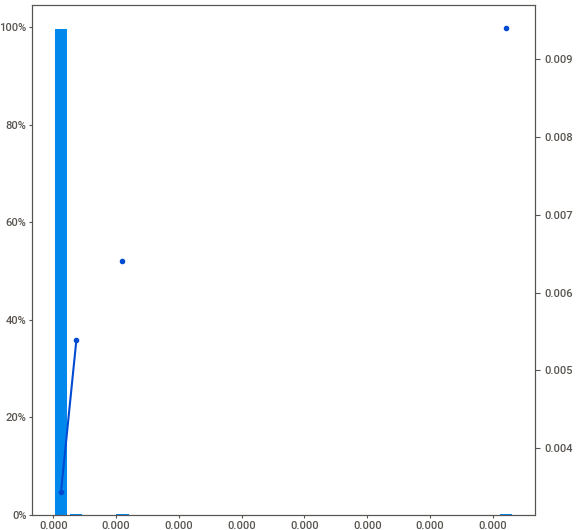
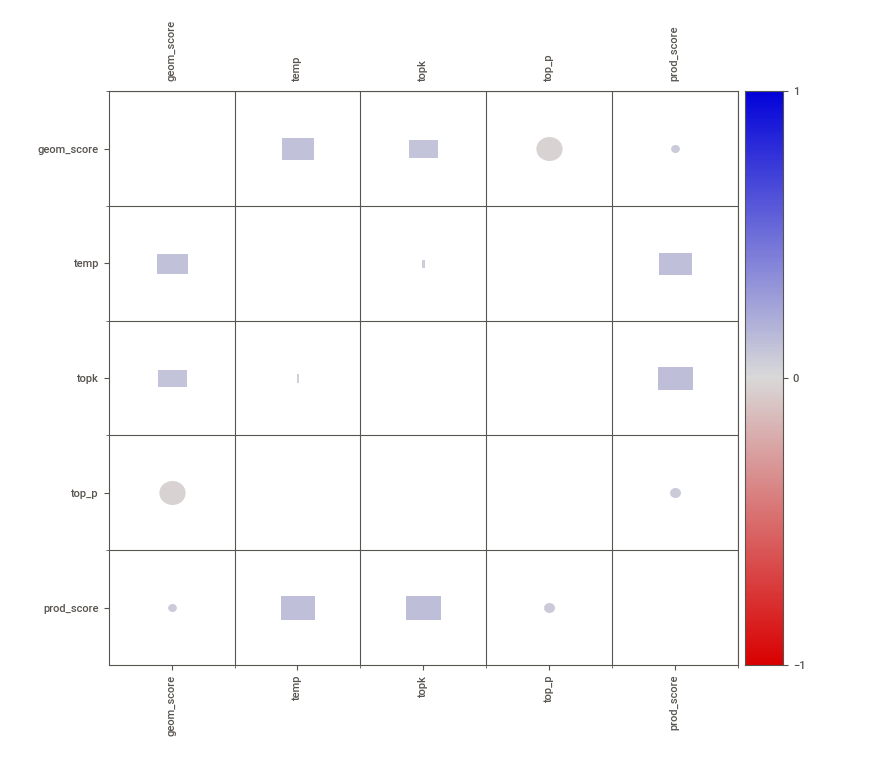
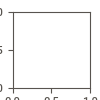

In [33]:


from IPython.display import HTML
HTML(sv_eda_name)

In [34]:
put_in_dropbox(sv_eda_name)

## pandas profiling 

In [35]:
gc.collect()

25655

In [36]:
!pip uninstall -y -q pandas-profiling
!pip install -U -q pandas-profiling

import numpy as np
from pandas_profiling import ProfileReport

     |████████████████████████████████| 261 kB 12.7 MB/s 
     |████████████████████████████████| 10.1 MB 85.6 MB/s 
     |████████████████████████████████| 596 kB 54.6 MB/s 
     |████████████████████████████████| 62 kB 958 kB/s 
     |████████████████████████████████| 675 kB 54.0 MB/s 
     |████████████████████████████████| 3.1 MB 43.1 MB/s 
     |████████████████████████████████| 102 kB 14.9 MB/s 
     |████████████████████████████████| 812 kB 69.1 MB/s 
     |████████████████████████████████| 28.5 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.9.1+cu111 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.4 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompati

In [37]:
gc.collect()

50

In [38]:
df_profile = df_analysis[['temp', 'topk', 'top_p',
                          'geom_score', 'model_response']]
profile = ProfileReport(df_profile, dark_mode=True,
                        title="GPT-Peter Hyperparam Opt (Sentence Score)",
                        explorative=True)


profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:

pd_eda_name = "GPT-Peter Hyperparam Opt-EDA-{}.html".format(today_string)
profile.to_file(pd_eda_name)

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
put_in_dropbox(pd_eda_name)
print("saved - ", datetime.now())

saved -  2021-10-20 04:28:34.425447
